### Pre-talk notes for Speaker!
During talk:
* Minimise file browser
* move to this folder cd .\Documents\GitHub\working-with-twitter-data\
* Zoom in
* Clear cells
* Share public link -> * Share public link -> https://github.com/UKDataServiceOpen/working-with-twitter-data/blob/main/TidyingDemo.ipynb

Talk time - 20 minutes

# Twarc Tidying and Analysis
This notebook will cover the exploration, tidying up and some basic analysis of the data collected by the [TwarcDemo in this repo](https://github.com/UKDataServiceOpen/working-with-twitter-data/blob/main/TwarcDemo.ipynb)

We will be using the 1000 Vegan Tweets from "Veganuary" 2019. If I didn't show a Twarc demo before you can find these in `data/demoData.csv`, and if you didn't follow along there is a provided version of this data.

So let's import some packages and read it in. 

In [188]:
# Import our packages for data viz and UKDS color palette
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plot styles
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 28,
                    'figure.figsize':(28,12)})

# set seaborn style
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

# create UKDS color palette
# colors = ['#E03A6C', '#F5AD42', '#6C2B76']
colors = ['#E03A6C', '#F5AD42', '#ECE64B', '#449858', '#43A6C6', '#6C2B76']

# use n_colors to allow the colors to cycle
palette = sns.set_palette(sns.color_palette(colors), n_colors=100)

In [189]:
# Tweak default plotting styles
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 22,
                    'figure.figsize':(24,8)})

In [190]:
# Read our data into a dataframe using pandas
data = pd.read_csv('3monthCoughUK.csv', parse_dates=['created_at'])

# The head function prints out the first 5 rows.
data.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73
0,1476704208074289156,1476701470447874050,1.476703e+18,NaN,NaN,181521084,1.226233e+08,NaN,NaN,2021-12-30 23:58:13+00:00,...,"[-1.315192, 53.1109178, -1.229692, 53.148616]",Feature,0f4224b306ddf55e,Sutton in Ashfield,0f4224b306ddf55e,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
1,1476702886050648077,1476701470447874050,1.476701e+18,NaN,NaN,181521084,1.815211e+08,NaN,NaN,2021-12-30 23:52:58+00:00,...,"[-1.315192, 53.1109178, -1.229692, 53.148616]",Feature,0f4224b306ddf55e,Sutton in Ashfield,0f4224b306ddf55e,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
2,1476701874116083712,1476686827331461128,1.476687e+18,NaN,NaN,1352804201101991941,6.538482e+07,NaN,NaN,2021-12-30 23:48:57+00:00,...,"[-1.2894037, 52.5436614, -1.2730678, 52.5567908]",Feature,223a7c85e7e3ff1b,Stoney Stanton,223a7c85e7e3ff1b,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
3,1476697453919408135,1476686090111275009,1.476697e+18,NaN,NaN,1318834717295300609,3.578058e+09,NaN,NaN,2021-12-30 23:31:23+00:00,...,"[0.0748022, 51.4087608, 0.1889376, 51.478931]",Feature,569c1d39d5de5775,Bexley,569c1d39d5de5775,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
4,1476694735628779526,1476397481869160455,1.476397e+18,NaN,NaN,390000120,3.547992e+09,NaN,NaN,2021-12-30 23:20:35+00:00,...,"[-2.659936, 51.399367, -2.510844, 51.516387]",Feature,7f15dd80ac78ef40,Bristol,7f15dd80ac78ef40,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN


We can test our tweets are real by taking the ID from the first column and replacing the ID in any tweet we can find, which I will demo!

So we've got our data read in successfully, let's print out some of the tweet text to make sure they have something to do with veganism.

In [191]:
for index in [1,2,3,4,5]:
    print(data['text'][index])
    print('\n')


I sneeze a lot in general sometimes for no apparent reason.


@darrenmark69 Is sneezing the difference? Don't ever remember that being listed as a symptom for coN vid (not that I believe anything they say about it anyway)


@petewall41 A week!!! Ffs. I had the shivers bad yesterday evening, cold one minute and hot the next. Bad fatigue, weakness, stiff muscles. It's been loads of fun 🤦‍♂️


@waywardscots Definitely over 40, and had all those side effects since mine, yesterday morning. Working from home, and had to lie down for a couple of hours this afternoon because I didn't even have the strength to lift my arms to type. Joints aching, full body shivers and a horrific headache.


@ItsMeNatashaP She reckons she's coming to the end of it as she's been coughing for a few days. I done a test earlier and was negative. Never say never though 😂




In [192]:
# I always recommend running info() for basic type information.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7097 entries, 0 to 7096
Data columns (total 74 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   id                                     7097 non-null   int64              
 1   conversation_id                        7097 non-null   int64              
 2   referenced_tweets.replied_to.id        3692 non-null   float64            
 3   referenced_tweets.retweeted.id         0 non-null      float64            
 4   referenced_tweets.quoted.id            369 non-null    float64            
 5   author_id                              7097 non-null   int64              
 6   in_reply_to_user_id                    3794 non-null   float64            
 7   retweeted_user_id                      0 non-null      float64            
 8   quoted_user_id                         369 non-null    float64            
 9   created_

In [193]:
# and decribe() for statistical info.
# data.describe()
# Or to supress scientific notation
data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count']].describe().apply(lambda s: s.apply('{0:.0f}'.format))

,author.public_metrics.followers_count,public_metrics.like_count,public_metrics.retweet_count
count,7097,7097,7097
mean,2560,6,0
std,7492,110,6
min,0,0,0
25%,384,0,0
50%,951,1,0
75%,2381,3,0
max,236203,8653,298


At this point I am thinking we have too many columns to analyse really. It's worth at this point asking if there is anything we could remove now. Though if we are exploring this may be premature.

At this point it's probably time to narrow down what we are doing, there is too much interesting information in this dataset.

I am going to keep the following:
* id - The Tweet ID
* created_at - The time the tweet was created
* text - the text that makes up a tweet
* author.id - the author ID
* author.created_at - when the users account was created
* author.username - the Twitter users username
* author.location - a self-defined location
* author.public_metrics.followers_count - Number of followers a user has
* geo.full_name - the full name describing a tweets geolocation
* public_metrics.like_count - number of likes on this tweet
* public_metrics.retweet_count - number of retweets on this tweer.

In [194]:
data = data[['id','created_at', 'text','author.id','author.created_at', 'author.username','author.location','author.public_metrics.followers_count','geo.full_name','public_metrics.like_count','public_metrics.retweet_count']]
data.head()

,id,created_at,text,author.id,author.created_at,author.username,author.location,author.public_metrics.followers_count,geo.full_name,public_metrics.like_count,public_metrics.retweet_count
0,1476704208074289156,2021-12-30 23:58:13+00:00,"@planet_leesti Many things make me sneeze, som...",181521084,2010-08-22T12:08:39.000Z,Traceyspacey1,NaN,1016,"Sutton in Ashfield, England",0,0
1,1476702886050648077,2021-12-30 23:52:58+00:00,I sneeze a lot in general sometimes for no app...,181521084,2010-08-22T12:08:39.000Z,Traceyspacey1,NaN,1016,"Sutton in Ashfield, England",0,0
2,1476701874116083712,2021-12-30 23:48:57+00:00,@darrenmark69 Is sneezing the difference? Don'...,1352804201101991941,2021-01-23T02:24:13.000Z,darren_buckler,"Leicester, England",1420,"Stoney Stanton, England",0,0
3,1476697453919408135,2021-12-30 23:31:23+00:00,@petewall41 A week!!! Ffs. I had the shivers b...,1318834717295300609,2020-10-21T08:41:30.000Z,Webbo2306,NaN,421,"Bexley, London",1,0
4,1476694735628779526,2021-12-30 23:20:35+00:00,"@waywardscots Definitely over 40, and had all ...",390000120,2011-10-13T09:34:39.000Z,WrittenInRain,"Bristol, UK",753,"Bristol, England",2,0


# Have covid-19 symptoms grown?
Those of us still checking the news will know that in late November we had the Omicron strain develop. I have included a dataset "covid_data" which contains new case numbers in the UK from https://ourworldindata.org/explorers/coronavirus-data-explorer

Creating a plot as seen below.

In [195]:
covid = pd.read_csv('covid_data.csv', parse_dates=['date'])
covid = covid.set_index('date')

[Text(0.5, 1.0, 'Number of covid cases over time')]

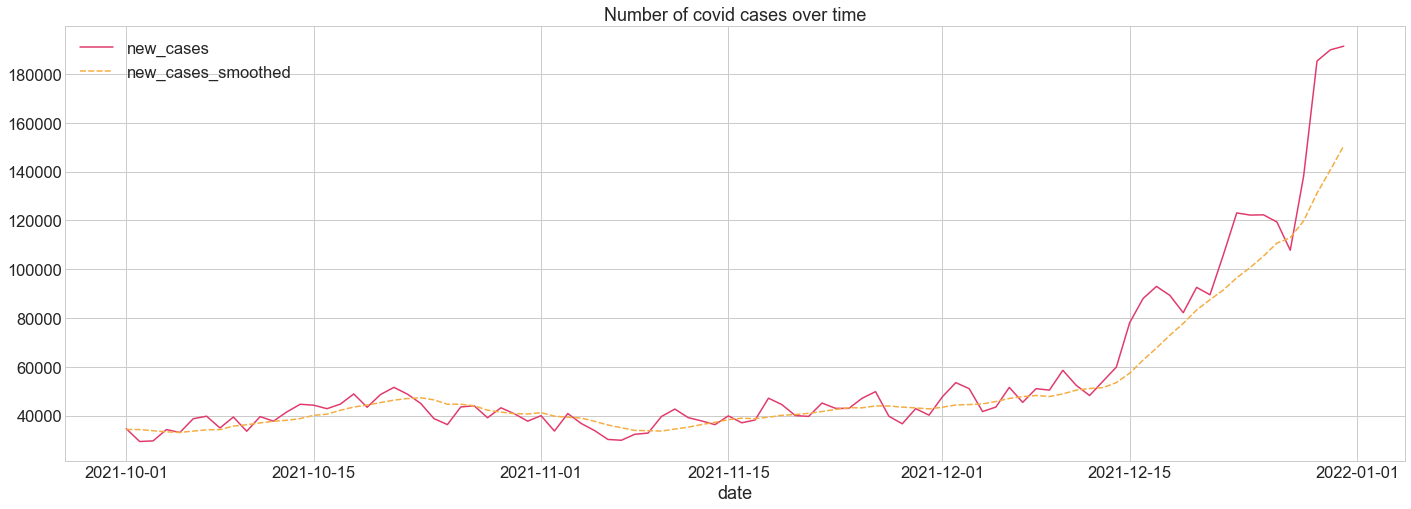

In [196]:
sns.lineplot(data=covid).set(title='Number of covid cases over time')

[Text(0.5, 1.0, 'Number of tweets containing covid symptoms in UK over time')]

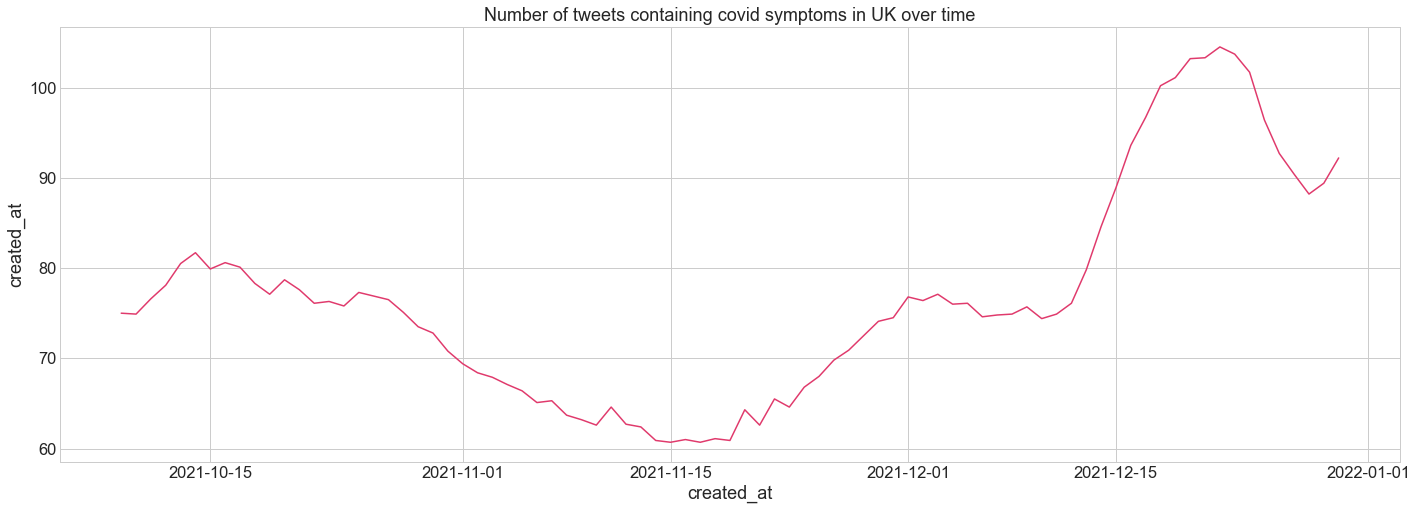

In [197]:
sns.lineplot(data=data['created_at'].groupby(data.created_at.dt.date).count().rolling(10).mean()).set(title='Number of tweets containing covid symptoms in UK over time')

My first question is do our tweets reflect this general increase, and hence could we predict these spikes from users self-reporting symptoms.

It does appear that there is at the very least a correlation here. Though whether this is particularly down to our users self reporting, or from the media creating a hypochondriac effect, mixed with the self-gratifying nature of social media. This is hard to tell.

# Symtpoms over time

We can go a step further though, we could for example try to break down counts per day for tweets which contain our named symptoms. This could help us seperate out omicron hype from the delta hype. Omicron sufferers generally seem to have more of a sneeze and headache illness than the coughs we previously assocaited with covid-19. We can try to visualize this too.

In [198]:
data['has_cough'] = data.text.str.contains('cough') | data.text.str.contains('coughing')
data['has_sneeze'] = data.text.str.contains('sneeze') | data.text.str.contains('sneezing')
data['has_fatigue'] = data.text.str.contains('fatigue')
data['has_headache'] = data.text.str.contains('headache')

# fatigue, sneeze, sneezing, headache
data[['has_cough','has_sneeze','has_fatigue','has_headache']].describe()

,has_cough,has_sneeze,has_fatigue,has_headache
count,7097,7097,7097,7097
unique,2,2,2,2
top,True,False,False,False
freq,3560,6430,6341,5082


In [199]:
for index in [1,2,3]:
    print(data[data.has_cough == True].reset_index()['text'][index])
    print('\n')

Missus tested positive for Covid today, she feels totally fine and the only reason she tested was cos she had a cough. I had my booster yesterday morning and since 4pm yesterday I've felt absolutely dreadful. How absurd is it that she has the virus but feels better than me? 🤦‍♂️


@BrandonButch I have had a cough for around 4 weeks- went to take PCR where I live and came back negative.


@KristyLKnapp Thanks lovely. Feeling okay. Just a cough, maybe a bit of a fever tonight. Im only 12 hours in.




In [200]:
for index in [1,2,3]:
    print(data[data.has_sneeze == True].reset_index()['text'][index])
    print('\n')

I sneeze a lot in general sometimes for no apparent reason.


@darrenmark69 Is sneezing the difference? Don't ever remember that being listed as a symptom for coN vid (not that I believe anything they say about it anyway)


@vinniephilpott @jtomsett93 big sneeze maybe




In [201]:
for index in [1,2,3]:
    print(data[data.has_fatigue == True].reset_index()['text'][index])
    print('\n')

@CabbyDes It's been terrible mate. Fever, shaking, fatigue, swelling under armpit, heart pounding. Was quite scary at one point mate. Starting to feel bit better now


@ProperCabby I was shaking uncontrollably with fever, feeling cold then hot, heart started pounding at one point, whole body was stiff, fatigue, even struggled to get out the bath earlier. It really was awful mate. Starting to feel a little more normal now, hoping to get out in cab tomorrow


Now Brendan Rodgers has jumped on the players welfare/ fatigue bandwagon! Wonder how many games some Celtic players were playing when they won everything under him ! Can’t remember him saying anything then 🤷🏽




In [202]:
for index in [1,2,3]:
    print(data[data.has_headache == True].reset_index()['text'][index])
    print('\n')

@mrmterry I suffered from pressure headaches for ages, got to the point where I waking up with a headache, going to sleep with a headache, got really depressed. Tried an over the counter Sudafed tablet(s) from my chemist, took a day or so but it worked!


@mrmterry Pressure headache?


Day 3 #COVID19. slept,slept,slept headache gone, aches and pains gone, cough gone...just exhausted. Mrs M the better patient still nausea and exhausted.  over the worst! #Covid #coronavirus




# TODO FIGUIRE OUT HOW TO DOA GROUPED BY PLOT OF THIS

<AxesSubplot:xlabel='created_at'>

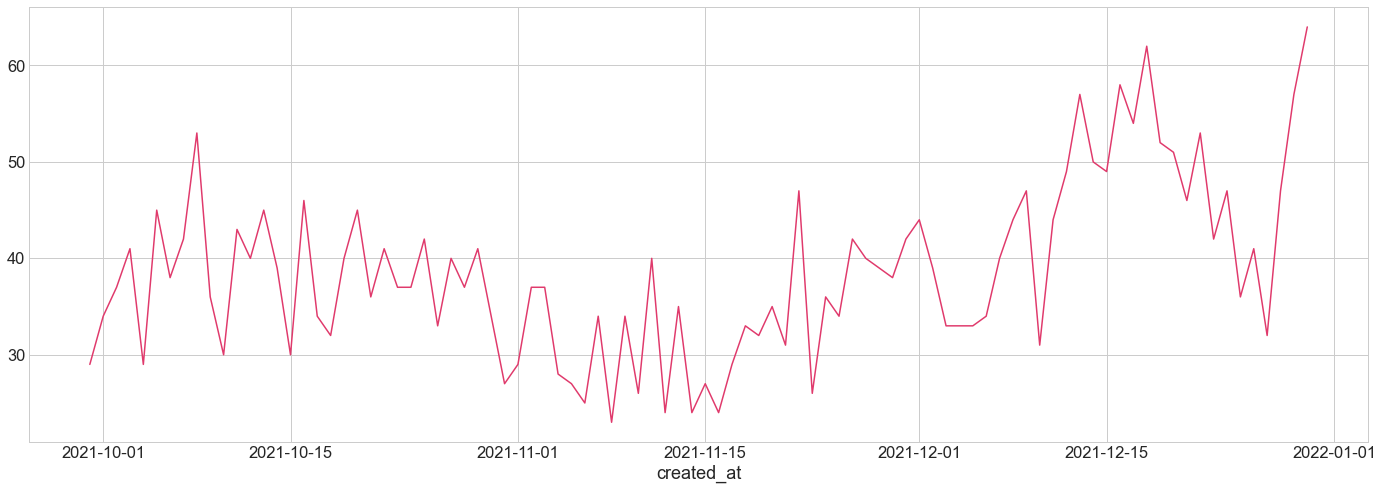

In [246]:
data.groupby(data.created_at.dt.date).has_cough.sum().plot()

In [203]:
data[['has_cough','created_at']].head()

,has_cough,created_at
0,False,2021-12-30 23:58:13+00:00
1,False,2021-12-30 23:52:58+00:00
2,False,2021-12-30 23:48:57+00:00
3,False,2021-12-30 23:31:23+00:00
4,False,2021-12-30 23:20:35+00:00


<AxesSubplot:xlabel='created_at', ylabel='has_cough'>

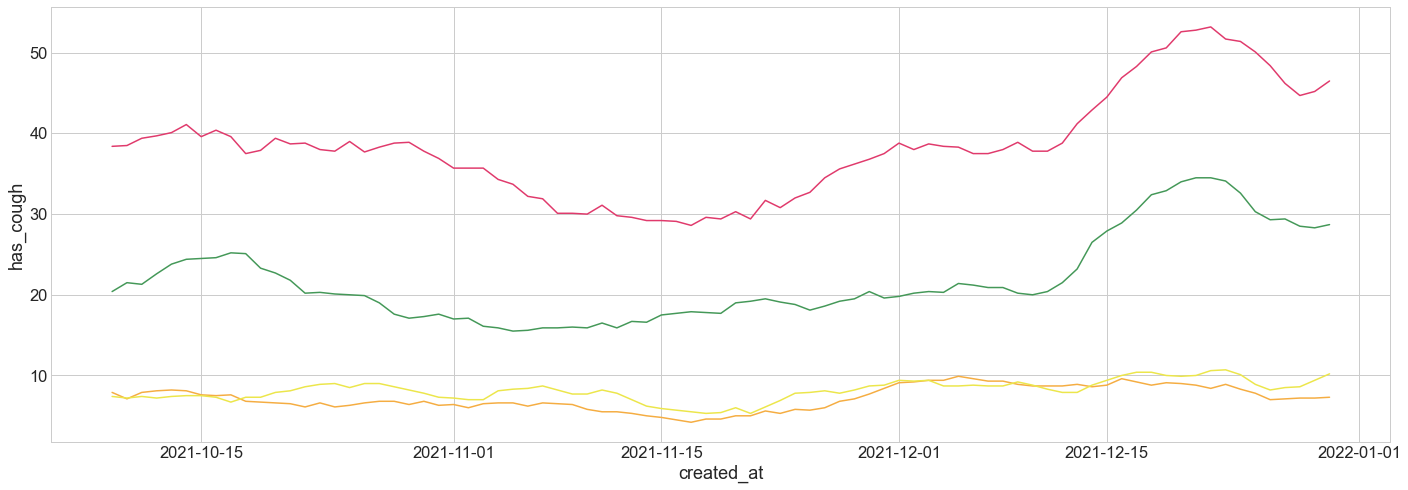

In [257]:
sns.lineplot(data = data.groupby(data.created_at.dt.date).has_cough.sum().rolling(10).mean())
sns.lineplot(data = data.groupby(data.created_at.dt.date).has_sneeze.sum().rolling(10).mean())
sns.lineplot(data = data.groupby(data.created_at.dt.date).has_fatigue.sum().rolling(10).mean())
sns.lineplot(data = data.groupby(data.created_at.dt.date).has_headache.sum().rolling(10).mean())

# Have we missed a symptom?

My next hunch comes from a tweet like these:
"Fever, shaking, fatigue, swelling under armpit, heart pounding. Was quite scary at one point mate. Starting to feel bit better now"
"slept,slept,slept headache gone, aches and pains gone, cough gone"

Users seem to be reporting symptoms I wasn't looking for like:
- sleeping
- heart pounding
- shaking
- swelling

To find these, it might be worth looking for words which appear with our terms. To begin lets simply take a word frequency count.

In [205]:
# import our NLP library
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [206]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)
word_dist = nltk.FreqDist(words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])

In [207]:
wordCount.head(10)

,Word,Frequency
0,.,8262
1,@,6636
2,a,6031
3,",",6029
4,I,5768
5,the,4841
6,and,4375
7,to,3937
8,’,2988
9,cough,2687


Our most common words largely contain punctuation and what are called in NLP "stop words", these are words that traditionally add no context to a sentence like I, you, a, the, but etc.

In [208]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

word_dist = nltk.FreqDist(new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])

In [209]:
wordCount.head(10)

,Word,Frequency
0,a,6031
1,I,5768
2,the,4841
3,and,4375
4,to,3937
5,cough,2687
6,of,2539
7,it,2180
8,in,1971
9,headache,1937


Punctuation is gone, now let's remove "stopwords". NLTK actually has a list of these

In [210]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [222]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [235]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
from stop_words import get_stop_words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]

word_dist = nltk.FreqDist(filtered_new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [236]:
wordCount.head(10)

,Word,Frequency
0,cough,2687
1,headache,1937
2,https,1365
3,coughing,1083
4,amp,859
5,like,727
6,fatigue,721
7,got,651
8,cold,576
9,get,560


We don't have all of them here, but we do have a lot of them. I in particular has been skipped because we haven't lowercased all our words when we tokenize them.

In [238]:
# split text by whitespace
# we add in a lower() function
wordlist = data['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
from stop_words import get_stop_words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]

word_dist = nltk.FreqDist(filtered_new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [239]:
wordCount.head(10)

,Word,Frequency
0,cough,2919
1,headache,2092
2,https,1365
3,coughing,1141
4,amp,859
5,covid,849
6,fatigue,789
7,like,746
8,got,723
9,cold,624


finally we are likely underreporting any word here that can be conjugated.
Think words like:
- swim
- swam
- swimming

all refer to the "stem" swim. We will experience this with:
- cough
- coughed
- coughing

So it's worth merging these.

In [240]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [241]:
# split text by whitespace
# we add in a lower() function
wordlist = data['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
from stop_words import get_stop_words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]
stems = [ps.stem(word) for word in filtered_new_words if word.isalnum()]

word_dist = nltk.FreqDist(stems)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [243]:
ps.stem('fatigued')

'fatigu'

In [242]:
wordCount.head(10)

,Word,Frequency
0,cough,4096
1,headach,2158
2,http,1365
3,day,1018
4,feel,879
5,get,874
6,amp,859
7,covid,852
8,fatigu,801
9,like,772


In [ ]:
to do
conjugate stems to something normal
capitalize all words
remove web terms like https, amp

# Sentiment of symptoms over time?

## How is Veganism percieved on Twitter?
In order to answer this question we need to introduce sentiment analysis. This is quite easy to do in Python as complicated as it sounds. As with many complicated things, somebody has written a package to make this easy for us.


In [ ]:
# Import NLTK, the Natural Language package
import nltk
# Download the popular vader lexicon of words and sentiments.
nltk.download([
    "vader_lexicon",
])

# import the sentiment analyser.
from nltk.sentiment import SentimentIntensityAnalyzer

# Create a new sentiment analyser.
sia = SentimentIntensityAnalyzer()

# And write a function we can pass to our pandas function
def get_sentiment(string):
    return sia.polarity_scores(string)['compound']

With this package our sentiment scores are returned on a scale of -1 for fully negative, to +1 for fully positive.
So our below sentence "I love cats" has a sentiment of 0.6, we high positive sentiment. Whereas "I hate cats is lower in sentiment.

In [ ]:
# Test our sentiment package
get_sentiment('I love cats')

In [ ]:
# Test our sentiment package
get_sentiment('I hate cats')

In [ ]:
# Test our sentiment package
get_sentiment('I am cats')

In [ ]:
# sentiment by word demo function
def sentiment_by_word(string):
    for word in string.split(' '):
        print(word + ' -- ' + str(get_sentiment(word)))

sentiment_by_word('I love cats')

In [ ]:
# So let's apply this to our entire dataframe
data['sentiment'] = data['text'].apply(get_sentiment)

# print a few rows
for index in [0,1,2,3,4]:
    print('sentiment ' + str(data['sentiment'][index]))
    print(data['text'][index])
    print('\n')

### What can we do with our sentiment scores
To start with, let's find our highest sentiment tweet.


In [ ]:
data.sort_values(by='sentiment', ascending=False).head()

In [ ]:
topSentimentIndex = 156
print(data['id'][topSentimentIndex])
print(data['text'][topSentimentIndex])
print(data['sentiment'][topSentimentIndex])

In [ ]:
sentiment_by_word(data['text'][topSentimentIndex])

In [ ]:
# And how about the lowest sentiment?
data.sort_values(by='sentiment', ascending=True).head()

In [ ]:
bottomSentimentIndex = 104
print(data['id'][bottomSentimentIndex])
print(data['text'][bottomSentimentIndex])
print(data['sentiment'][bottomSentimentIndex])

In [ ]:
sentiment_by_word(data['text'][bottomSentimentIndex])

In [ ]:
# Let's also grab some neutral tweets.
data[data['sentiment'] == 0]

In [ ]:
neutralIndex = 3
print(data['id'][neutralIndex])
print(data['text'][neutralIndex])
print(data['sentiment'][neutralIndex])

In [ ]:
sentiment_by_word(data['text'][neutralIndex])

In [ ]:
# Often the users at each end of this spectrum are quite different, lets see what our tweeters look like in general
data.sentiment.hist()

At a glance there are three different kinds of tweets here:
1. Negative tweets, these are likely complaints from vegans or complaints about vegans.
2. Neutral tweets, Most of the users appear to be neutral, this is usually a symptom that our sentiment analyser wasn't trained on the language it's predicting on, so is seeing words it's never classified before and tags them as neutral.
3. Positive tweets, these appear in abundance in comparison to negativity. Could this be a sign of positivity, marketing, bias?

On a hunch this grouping is quite naive. I could imagine a big difference in group 1:
* People complaining about vegans in a hateful way
* Vegans complaining about non-vegans in a hateful way
* Vegans complaining about vegan difficulties.

group 3 likely contains:
* Inflated self-promotion from vegan business owners
* Inflated promotion and feedback from large brands launching vegan products such as Greggs and the Vegan sausage roll.

These are all much larger project ideas, we don't even have a level of condience that any of these users are vegan.

### Most liked content
We have access to likes and retweets, let's check out what the most liked content is.

In [ ]:
# A fairly familiar graph of likes being geometrically hard to gain, with outliers from "viral" tweets
data['public_metrics.like_count'].hist(bins=100)

In [ ]:
# And we see similar with retweets, even harder to come by as an echo of messaging rather than approval.
data['public_metrics.retweet_count'].hist(bins=20)

In [ ]:
# And how about the most liked tweet?
data.sort_values(by='public_metrics.like_count', ascending=False).head()

In [ ]:
mostLikedIndex = 1012
print(data['id'][mostLikedIndex])
print(data['text'][mostLikedIndex])
print(data['sentiment'][mostLikedIndex])

In [ ]:
sentiment_by_word(data['text'][mostLikedIndex])

In [ ]:
# And how about the most retweeted?
data.sort_values(by='public_metrics.retweet_count', ascending=False).head()

In [ ]:
mostRetweetedIndex = 1012
print(data['id'][mostRetweetedIndex])
print(data['text'][mostRetweetedIndex])
print(data['sentiment'][mostRetweetedIndex])

The most liked and most retweeted came from Boy George, there is a correlation there that we will look at later.

## Does the perception of Veganism change over time?
This is a toy example of what we saw in the presentation. How do we percieve a rolling sentiment over time.

Next let's sort this dataframe by date. Looking now we seem to have only a handful of minutes between our Tweets.

In [ ]:
# sort by date
# convert created at into a datetime object
data['created_at'] =pd.to_datetime(data.created_at)
# Sort our dataframe b dates
data = data.sort_values(by='created_at',ascending=True)
# reset index
data = data.reset_index()
del data['index']

# print the head
data.head()

In [ ]:
# To start with let's plot sentiment over index. Although this is linear, rather than time based it can be useful.
data['sentiment'].plot()

In [ ]:
# As each tweet is relatively unconnected we can get quite erratic plots, some smoothin can help.
data['sentiment'].rolling(30).mean().plot()

In [ ]:
# positive tweets
len(data[data['sentiment'] > 0])

In [ ]:
# neutral tweets
len(data[data['sentiment'] == 0])

In [ ]:
# negative tweets
len(data[data['sentiment'] < 0])

Most of our tweets are vegan, some or neutral, and few are negative.

Not much to see here, in the full veganuary dataset we see a kickoff of positively, a trend downward and then a celebration at the end of the month.

In [ ]:
# Our neutral tweets, generally introduce some high-sentiment content that our model doesn't understand yet, so maybe we should remove them.
data[data.sentiment != 0]['sentiment'].rolling(30).mean().plot()

In [ ]:
# plot with realistic time axis
data.plot(kind='scatter',x='created_at', y='sentiment')

As we are only looking at such a small sample it's hard to draw any conclusions from this data. Depending on what we follow this can be a very clear line that somewhat represents the sentiment of a topic over time. Diving into our neutral tweets to better classify could be a good next step.

### Does sentiment correlate with success?
Now we have quantified sentiment, do high sentiment messages get engagement?
Let's plot our:
* follower counts
* likes count
* retweet count
* sentiment 

And see what we find.

In [ ]:
corr = data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count','sentiment']].corr()
corr.style.background_gradient(cmap ='coolwarm')

My hunch is that as so many results have neutral sentiment this is probably shifting our correlations quite heavily, let's remove them for now.

In [ ]:
corr = data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count','sentiment']][data['sentiment'] != 0].corr()
corr.style.background_gradient(cmap ='coolwarm')

It seems that the more followers a user has, the more likely their content is to be liked and retweeted. Follower count does not correlate with the sentiment of tweets though.

Likes and retweets have a strong correlation, content that is likely to be retweeted is also likely to be liked.

In this case sentiment doesn't seem to correlate with any of these features though.

By this point, we have noticed that our neutral sentiment tweets are a bit of a missed oppurtunity. We understand sentiment generally, but do not understand the terms within our topic area. The word "carnivore" might be usual, but in vegan circles it can be used in disgust or even as an insult, our sentiment analyzer doesn't understand this.

A good next step would be trying to figure out what these words are, but I will leave this here for now.

## Future Work
* Getting a full word count from tweets
* Dealing with stop words, punctuation and hashtags
* Removing duplicate words through case sensitivity, fuzzy matching and stemming
* Making word clouds with [wordclouds.co.uk](https://www.wordclouds.co.uk/)
* Classifying types of tweet into marketing, self-promotion and true oppinion.

## Useful Links
* Word cloud builder - [wordclouds.co.uk](https://www.wordclouds.co.uk/)
* An intro to basic NLP and word clouds with WhatsApp data - [What can I do with WhatsApp?](https://towardsdatascience.com/what-can-i-do-with-whatsapp-661fc3cdd5c5)
* Use machine learning to understand and leverage text. - [Solving 90% of NLP](https://www.kdnuggets.com/2019/01/solve-90-nlp-problems-step-by-step-guide.html)